# PAXG Price logger
Sam Greydanus | December 2022 | MIT License

In [41]:
# !pip install ccxt
# !pip install Nasdaq-Data-Link

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time, random, requests, re, os, datetime, argparse

In [2]:
import ccxt, nasdaqdatalink
import numpy as np
import matplotlib.pyplot as plt

from paxg import logging_loop  # this is in the same directory as this .ipnyb

from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

from matplotlib import rcParams
def figsize(width,height):
    rcParams['figure.figsize'] = (width,height)

%matplotlib inline
figsize(17,5)
rcParams['font.size'] = 14

## Start a job logging data in the background

In [3]:
# handle hyperparams
class ObjectView(object):  # make a dictionary look like an object
    def __init__(self, d): self.__dict__ = d

def get_args(as_dict=False):
    arg_dict = {'logfile': 'prices.csv',
                'interval': 10,
                'verbose': False}
    return arg_dict if as_dict else ObjectView(arg_dict)

# logging_loop(get_args())
# jobs.new('logging_loop(get_args())')

In [4]:
jobs.status()

In [6]:
# jobs[0]

## Basic visualizations

In [11]:
import pandas as pd
df = pd.read_csv("prices.csv")
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df[-5:]

,time,xau,paxg
158,2022-12-29 22:03:32,1818.89,1812.38
159,2022-12-29 22:03:43,1818.89,1812.38
160,2022-12-29 22:03:54,1818.89,1812.38
161,2022-12-29 22:04:06,1818.89,1812.38
162,2022-12-29 22:04:17,1818.89,1812.38


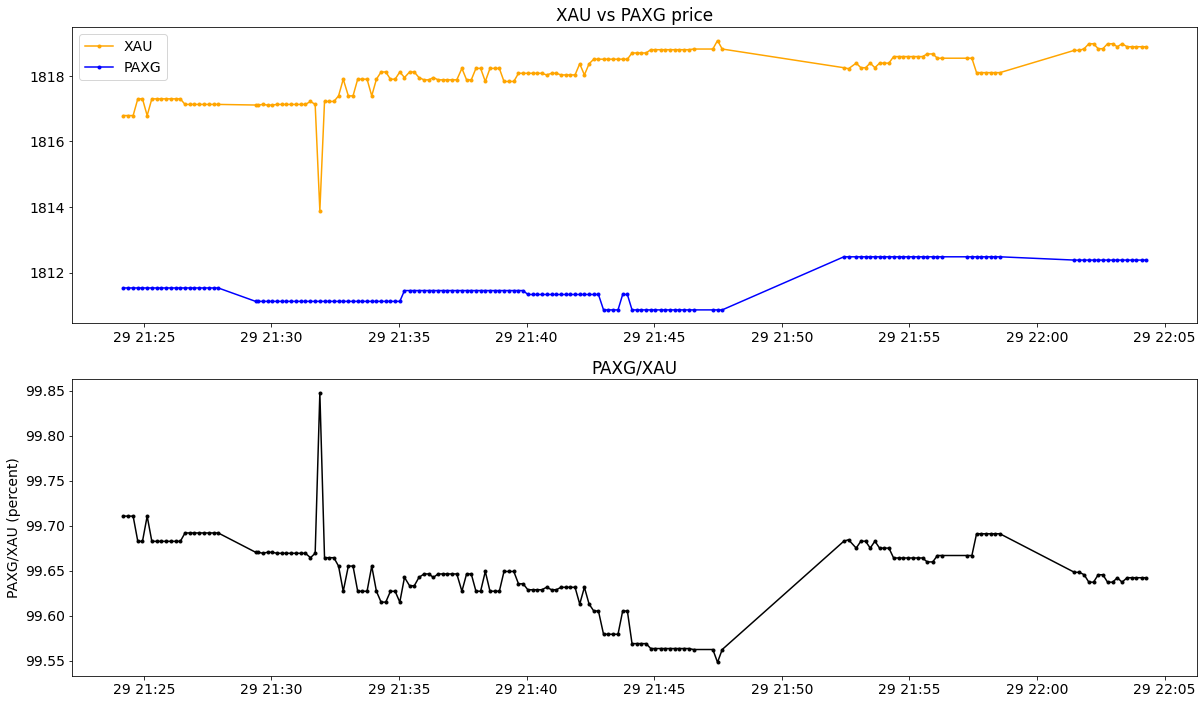

In [12]:
figsize(17,10)

plt.subplot(2,1,1)
plt.title('XAU vs PAXG price')
plt.plot(df['time'], df['xau'], '.-', color='orange', label='XAU')
plt.plot(df['time'], df['paxg'], '.-', color='blue', label='PAXG')
plt.legend()

plt.subplot(2,1,2)
plt.title('PAXG/XAU')
plt.plot(df['time'], 100*df['paxg']/df['xau'], '.-', color='black')
plt.ylabel('PAXG/XAU (percent)')

plt.tight_layout() ; plt.show()

In [52]:
# def iso2timestamp(iso):
#     ts = datetime.datetime.fromisoformat(iso).timestamp()
#     return int(ts)

# def get_params(**kwargs):
#     p = {'start_time': iso2timestamp('2021-05-15 00:00:00.000000'),
#        'end_time': datetime.datetime.now(),
#        'resolution': 60, 'market_name': 'BTC/USD'}
#     p.update(kwargs)
#     return p

# exch = ccxt.kraken()

#token = 'PAXG/USD'
# start_time = '2022-12-01 00:00:00.000000'
# end_time = datetime.datetime.now()
# params = get_params(market_name=token, start_time=start_time, end_time=end_time)

# x = np.array(exch.fetch_ohlcv(token, '1h', params=params))[:,1]
# t = pd.date_range(start=start_time, end=end_time, periods=len(x))


# fig = plt.figure(figsize=[10,3], dpi=120)
# plt.plot(t, x, color='black', linewidth=0.5)
# plt.ylabel('Price')

# plt.tight_layout() ; plt.show()

In [5]:
# def innocent_request(url):
#     n = random.randint(0,999)
#     headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'\
#            f'(KHTML, like Gecko) Chrome/75.0.3770.{n:03d} Safari/537.36', 'Cache-Control': 'no-cache'}
#     return requests.get(url, headers=headers).text

# def get_xau_price(text=None):
#     '''Takes in raw html from tradingeconomics.com as "text" parameter'''
#     if text is None:
#         text = innocent_request("https://tradingeconomics.com/")
#     gold_section_ix = text.find('<a href="/commodity/gold">')
#     xau_price = text[gold_section_ix:gold_section_ix+600].replace(' ', '').split('\r\n')[4]
#     try:
#         xau_price = float(xau_price)
#     except:
#         raise ValueError('Maybe web scrape failed; this string should be a gold price: "{}"'.format(xau_price))
#     return xau_price

# def get_paxg_price(text=None):
#     '''Takes in raw html from coinmarketcap.com as "text" parameter'''
#     if text is None:
#         text = innocent_request("https://coinmarketcap.com/currencies/pax-gold/")
#     gold_section_ix = text.find('<strong>PAX Gold Price</strong>')
#     paxg_price = re.split('<td>|</td>', text[gold_section_ix:gold_section_ix+100])[1]
#     paxg_price = paxg_price.replace('$', '').replace(',', '')
#     try:
#         paxg_price = float(paxg_price)
#     except:
#         raise ValueError('Maybe web scrape failed; this string should be a gold price: "{}"'.format(paxg_price))
#     return paxg_price

# def logging_loop(args, verbose=True):
#     if not os.path.isfile('prices.csv'):
#         with open('prices.csv', 'w') as f:
#             f.write('time,xau,paxg\n')
    
#     while True:
#         time.sleep(args.interval)
#         dt, xau, paxg = datetime.datetime.now(), get_xau_price(), get_paxg_price()
#         with open(args.logfile,'a') as f:
#             row = '{},{},{}\n'.format(dt.replace(microsecond=0).isoformat(), xau, paxg)
#             if verbose: print(row, end='')
#             f.write(row)
        
# args = get_args()
# logging_loop(args, verbose=True)

2022-12-29T21:47:18,1818.82,1810.86
2022-12-29T21:47:29,1819.08,1810.86
2022-12-29T21:47:40,1818.82,1810.86


KeyboardInterrupt: 